<h3>Load and preprocess data</h3>

In [1]:
import pandas as pd
import seaborn as sns
from src.recsys_utils import anaylze_item, build_profile, train_user_model
from string import punctuation
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

/home/zanehutchens/projects/recsys/env/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
book_df = pd.read_csv('data/books_data.csv')
book_df

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
212399,The Orphan Of Ellis Island (Time Travel Advent...,"During a school trip to Ellis Island, Dominick...",['Elvira Woodruff'],http://books.google.com/books/content?id=J7M-N...,http://books.google.com/books?id=J7M-NwAACAAJ&...,Scholastic Paperbacks,2000-06-01,http://books.google.com/books?id=J7M-NwAACAAJ&...,['Juvenile Fiction'],2.0
212400,Red Boots for Christmas,Everyone in the village of Friedensdorf is hap...,NaN,http://books.google.com/books/content?id=3n8k6...,http://books.google.com/books?id=3n8k6wl4BbYC&...,NaN,1995,http://books.google.com/books?id=3n8k6wl4BbYC&...,['Juvenile Fiction'],NaN
212401,Mamaw,"Give your Mamaw a useful, beautiful and though...",['Wild Wild Cabbage'],NaN,http://books.google.com/books?id=zytVswEACAAJ&...,NaN,2018-01-17,http://books.google.com/books?id=zytVswEACAAJ&...,NaN,NaN
212402,The Autograph Man,Alex-Li Tandem sells autographs. His business ...,['Zadie Smith'],http://books.google.com/books/content?id=JM6YV...,http://books.google.com/books?id=JM6YVPx_clMC&...,Vintage,2003-08-12,https://play.google.com/store/books/details?id...,['Fiction'],19.0


In [3]:
book_df = book_df.drop(columns = ['image', 'previewLink', 'ratingsCount', 'infoLink', 'publisher', 'publishedDate'])

In [4]:
book_df = book_df.dropna()
book_df.shape

(136138, 4)

In [5]:
book_df

,Title,description,authors,categories
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],['Biography & Autobiography']
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],['Religion']
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],['Fiction']
5,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],['Religion']
8,Saint Hyacinth of Poland,The story for children 10 and up of St. Hyacin...,['Mary Fabyan Windeatt'],['Biography & Autobiography']
...,...,...,...,...
212394,Final things,Grace's father believes in science and builds ...,['Jenny Offill'],['Fiction']
212397,The Magic of the Soul: Applying Spiritual Powe...,"""The Magic of the Soul, Applying Spiritual Pow...",['Patrick J. Harbula'],"['Body, Mind & Spirit']"
212398,Autodesk Inventor 10 Essentials Plus,Autodesk Inventor 2017 Essentials Plus provide...,"['Daniel Banach', 'Travis Jones']",['Computers']
212399,The Orphan Of Ellis Island (Time Travel Advent...,"During a school trip to Ellis Island, Dominick...",['Elvira Woodruff'],['Juvenile Fiction']


In [6]:
book_df['authors'] = book_df['authors'].apply(lambda x: ''.join([char for char in x if char not in punctuation]))
book_df['categories'] = book_df['categories'].apply(lambda x: ''.join([char for char in x if char not in punctuation]))
book_df['combined_text'] = book_df["Title"] + " " + book_df['description'] + " " + book_df['authors'] + " " + book_df['categories']
book_df

,Title,description,authors,categories,combined_text
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,Philip Nel,Biography Autobiography,Dr. Seuss: American Icon Philip Nel takes a fa...
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,David R Ray,Religion,Wonderful Worship in Smaller Churches This res...
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,Veronica Haddon,Fiction,Whispers of the Wicked Saints Julia Thomas fin...
5,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,Everett Ferguson,Religion,The Church of Christ: A Biblical Ecclesiology ...
8,Saint Hyacinth of Poland,The story for children 10 and up of St. Hyacin...,Mary Fabyan Windeatt,Biography Autobiography,Saint Hyacinth of Poland The story for childre...
...,...,...,...,...,...
212394,Final things,Grace's father believes in science and builds ...,Jenny Offill,Fiction,Final things Grace's father believes in scienc...
212397,The Magic of the Soul: Applying Spiritual Powe...,"""The Magic of the Soul, Applying Spiritual Pow...",Patrick J Harbula,Body Mind Spirit,The Magic of the Soul: Applying Spiritual Powe...
212398,Autodesk Inventor 10 Essentials Plus,Autodesk Inventor 2017 Essentials Plus provide...,Daniel Banach Travis Jones,Computers,Autodesk Inventor 10 Essentials Plus Autodesk ...
212399,The Orphan Of Ellis Island (Time Travel Advent...,"During a school trip to Ellis Island, Dominick...",Elvira Woodruff,Juvenile Fiction,The Orphan Of Ellis Island (Time Travel Advent...


In [7]:
book_df['vector_text'] = book_df['combined_text'].apply(lambda text: anaylze_item(text, 30, 8))

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 3.80 GiB of which 1.94 MiB is free. Including non-PyTorch memory, this process has 3.80 GiB memory in use. Of the allocated memory 3.44 GiB is allocated by PyTorch, and 279.70 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
book_df

,Title,description,authors,categories,combined_text,vector_text
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,Philip Nel,Biography Autobiography,Dr. Seuss: American Icon Philip Nel takes a fa...,"[[0.22360679774997896, 0.22360679774997896, 0...."
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,David R Ray,Religion,Wonderful Worship in Smaller Churches This res...,"[[0.19611613513818404, 0.19611613513818404, 0...."
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,Veronica Haddon,Fiction,Whispers of the Wicked Saints Julia Thomas fin...,"[[0.20412414523193154, 0.20412414523193154, 0...."
5,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,Everett Ferguson,Religion,The Church of Christ: A Biblical Ecclesiology ...,"[[0.6030226891555273, 0.30151134457776363, 0.4..."
8,Saint Hyacinth of Poland,The story for children 10 and up of St. Hyacin...,Mary Fabyan Windeatt,Biography Autobiography,Saint Hyacinth of Poland The story for childre...,"[[0.20412414523193154, 0.20412414523193154, 0...."
...,...,...,...,...,...,...
212394,Final things,Grace's father believes in science and builds ...,Jenny Offill,Fiction,Final things Grace's father believes in scienc...,"[[0.21320071635561041, 0.21320071635561041, 0...."
212397,The Magic of the Soul: Applying Spiritual Powe...,"""The Magic of the Soul, Applying Spiritual Pow...",Patrick J Harbula,Body Mind Spirit,The Magic of the Soul: Applying Spiritual Powe...,"[[0.17149858514250882, 0.34299717028501764, 0...."
212398,Autodesk Inventor 10 Essentials Plus,Autodesk Inventor 2017 Essentials Plus provide...,Daniel Banach Travis Jones,Computers,Autodesk Inventor 10 Essentials Plus Autodesk ...,"[[0.16666666666666666, 0.16666666666666666, 0...."
212399,The Orphan Of Ellis Island (Time Travel Advent...,"During a school trip to Ellis Island, Dominick...",Elvira Woodruff,Juvenile Fiction,The Orphan Of Ellis Island (Time Travel Advent...,"[[0.19611613513818404, 0.19611613513818404, 0...."


In [ ]:
ratings_df = pd.read_csv('data/Books_rating.csv') 

In [ ]:
ratings_df.columns

Index(['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/helpfulness',
       'review/score', 'review/time', 'review/summary', 'review/text'],
      dtype='object')

In [ ]:
ratings_df = ratings_df.drop(columns = ['Price', 'review/summary', 'review/time', 'review/helpfulness'])

<Axes: xlabel='review/score', ylabel='count'>

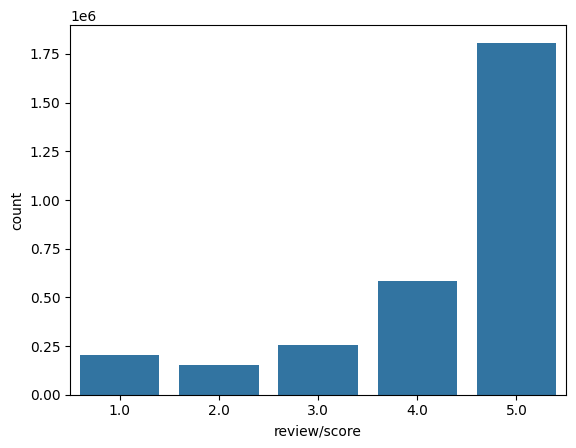

In [ ]:
sns.countplot(data = ratings_df, x = 'review/score')

In [ ]:
ratings_df = ratings_df.dropna()
ratings_df.shape

(2437899, 6)

In [ ]:
ratings_df

,Id,Title,User_id,profileName,review/score,review/text
0,1882931173,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",4.0,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,A30TK6U7DNS82R,Kevin Killian,5.0,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,A3UH4UZ4RSVO82,John Granger,5.0,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",4.0,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",4.0,Philip Nel - Dr. Seuss: American IconThis is b...
...,...,...,...,...,...,...
2999990,B000NSLVCU,The Idea of History,AI1QNMVF2E3TN,"Robin George ""Master of Arts""",5.0,Highly Recommended.This book is one of the bes...
2999994,B000NSLVCU,The Idea of History,AOFGOUMXLMVZS,"S. Grotzke ""scquest""",4.0,History is not a scientific process of cutting...
2999996,B000NSLVCU,The Idea of History,A1SMUB9ASL5L9Y,jafrank,4.0,This is pretty interesting. Collingwood seems ...
2999997,B000NSLVCU,The Idea of History,A2AQMEKZKK5EE4,"L. L. Poulos ""Muslim Mom""",4.0,"This is a good book but very esoteric. ""What i..."


In [ ]:
ratings_df['User_id'].value_counts()

User_id
A14OJS0VWMOSWO    5795
AFVQZQ8PW0L       3606
A1D2C0WDCSHUWZ    3146
AHD101501WCN1     1995
A1X8VZWTOG8IS6    1804
                  ... 
A2JKAA6J5CSV83       1
A6H09O9F6GCWY        1
AQJ0481R1GA0U        1
A3FY0NENDVFQDC       1
A18SQGYBKS852K       1
Name: count, Length: 1008896, dtype: int64

<p>is there enough data for a machine learning model?</p>

In [ ]:
ratings_df[ratings_df.User_id == 'A1D2C0WDCSHUWZ']['review/score'].value_counts()

review/score
5.0    2558
4.0     426
3.0      75
1.0      50
2.0      37
Name: count, dtype: int64

In [ ]:
user_df = pd.merge(ratings_df[ratings_df.User_id == "A1D2C0WDCSHUWZ"], book_df, on = 'Title')

In [ ]:
user_df['vector_text'][1].shape

(1, 19)

In [ ]:
user_df['vector_text'].apply(lambda vec: print(vec.shape))

(1, 19)
(1, 19)
(1, 18)
(1, 18)
(1, 18)
(1, 18)
(1, 18)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 18)
(1, 18)
(1, 18)
(1, 18)
(1, 18)
(1, 18)
(1, 18)
(1, 16)
(1, 18)
(1, 18)
(1, 18)
(1, 18)
(1, 18)
(1, 18)
(1, 18)
(1, 18)
(1, 18)
(1, 18)
(1, 18)
(1, 18)
(1, 18)
(1, 18)
(1, 18)
(1, 18)
(1, 19)
(1, 20)
(1, 18)
(1, 19)
(1, 20)
(1, 17)
(1, 17)
(1, 17)
(1, 17)
(1, 17)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 16)
(1, 16)
(1, 16)
(1, 16)
(1, 16)
(1, 16)
(1, 16)
(1, 16)
(1, 16)
(1, 16)
(1, 16)
(1, 16)
(1, 16)
(1, 16)
(1, 16)
(1, 16)
(1, 16)
(1, 16)
(1, 16)
(1, 17)
(1, 16)
(1, 18)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 17)
(1, 15)
(1, 15)
(1, 15)
(1, 15)
(1, 15)
(1, 15)
(1, 15)
(1, 15)
(1, 15)
(1, 15)
(1, 15)
(1, 15)
(1, 15)
(1, 15)
(1, 19)
(1, 19)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)


0       None
1       None
2       None
3       None
4       None
        ... 
2227    None
2228    None
2229    None
2230    None
2231    None
Name: vector_text, Length: 2232, dtype: object

In [ ]:
user_vector = build_profile(user_df['vector_text'].tolist())

user_df['user_vector'] = [user_vector.flatten()] * len(user_df)
user_df['vector_text'] = user_df['vector_text'].apply(lambda vec: vec.flatten())

ValueError: operands could not be broadcast together with shapes (1,19) (1,18) 

In [ ]:
user_df

,Id,Title,User_id,profileName,review/score,review/text,description,authors,categories,combined_text,vector_text
0,B000NSKB12,The Castle in the Attic,A1D2C0WDCSHUWZ,"E. A Solinas ""ea_solinas""",5.0,"What I would describe as early-fantasy, a book...",The classic children's story about a young boy...,Elizabeth Winthrop,Juvenile Fiction,The Castle in the Attic The classic children's...,"[[0.0, 0.13131821846575661, 0.1313182184657566..."
1,B000NSKB12,The Castle in the Attic,A1D2C0WDCSHUWZ,"E. A Solinas ""ea_solinas""",5.0,Don't be deceived by the relative slimness of ...,The classic children's story about a young boy...,Elizabeth Winthrop,Juvenile Fiction,The Castle in the Attic The classic children's...,"[[0.0, 0.13131821846575661, 0.1313182184657566..."
2,B000J5KSK8,The Gods of Mars,A1D2C0WDCSHUWZ,"E. A Solinas ""ea_solinas""",4.0,"When we last saw John Carter, he had been acci...",The Barsoom series continues: John Carter retu...,Edgar Rice Burroughs,Fiction,The Gods of Mars The Barsoom series continues:...,"[[0.10862159782423844, 0.10862159782423844, 0...."
3,B000I83ZJC,The Forsythe Saga,A1D2C0WDCSHUWZ,"E. A Solinas ""ea_solinas""",5.0,"Family secrets, dirty little problems, gamblin...",The Forsyte Saga was the title originally dest...,John Galsworthy,Fiction,The Forsythe Saga The Forsyte Saga was the tit...,"[[0.08512565307587486, 0.08512565307587486, 0...."
4,B000I83ZJC,The Forsythe Saga,A1D2C0WDCSHUWZ,"E. A Solinas ""ea_solinas""",4.0,"Family secrets, dirty little problems, and a d...",The Forsyte Saga was the title originally dest...,John Galsworthy,Fiction,The Forsythe Saga The Forsyte Saga was the tit...,"[[0.08512565307587486, 0.08512565307587486, 0...."
...,...,...,...,...,...,...,...,...,...,...,...
2227,0618092838,Knockabeg: A Famine Tale,A1D2C0WDCSHUWZ,"E. A Solinas ""ea_solinas""",5.0,"Mary Lyons crafts an enjoyable fantasy, rather...",The faeries of Knockabeg become involved in th...,Mary E Lyons,Juvenile Fiction,Knockabeg: A Famine Tale The faeries of Knocka...,"[[0.22360679774997896, 0.22360679774997896, 0...."
2228,0060762004,Forest of the Pygmies (Large Print),A1D2C0WDCSHUWZ,"E. A Solinas ""ea_solinas""",1.0,Isabel Allenge's tepid trilogy finally ends in...,Eighteen-year-old Alexander Cold and his grand...,Isabel Allende,Juvenile Fiction,Forest of the Pygmies (Large Print) Eighteen-y...,"[[0.2182178902359924, 0.2182178902359924, 0.21..."
2229,0141008253,Everything Is Illuminated,A1D2C0WDCSHUWZ,"E. A Solinas ""ea_solinas""",4.0,Jonathan Safran Foer takes literary risks and ...,Hoe vervullen we onze conflicterende taken als...,Jonathan Safran Foer,Fiction,Everything Is Illuminated Hoe vervullen we onz...,"[[0.04885319687460315, 0.0977063937492063, 0.0..."
2230,B000GW4AH6,Dandelion Wine,A1D2C0WDCSHUWZ,"E. A Solinas ""ea_solinas""",5.0,"I wasn't alive in 1928, and probably neither a...","In the unusual world of Green Town, Illinois, ...",Ray Bradbury,Fiction,Dandelion Wine In the unusual world of Green T...,"[[0.23570226039551587, 0.23570226039551587, 0...."


In [ ]:
vector_text_df = pd.DataFrame(data = user_df["vector_text"].tolist())
vector_text_df.fillna(value = 0, inplace = True)

user_vector_df = pd.DataFrame(data = user_df["user_vector"].tolist())
model_df = pd.concat((vector_text_df, user_vector_df, user_df['review/score']), axis = 1)

In [ ]:
predictions, true_scores = train_user_model(model_df.drop(columns = 'review/score'), model_df["review/score"], "regression", True)

=========== EVALUATION ===========
RMSE: 0.6093615190700177
R2_SCORE: 0.34497870822358023


<p>it doesnt seem to work that well :( I wonder whats wrong. Not enough data?</p>

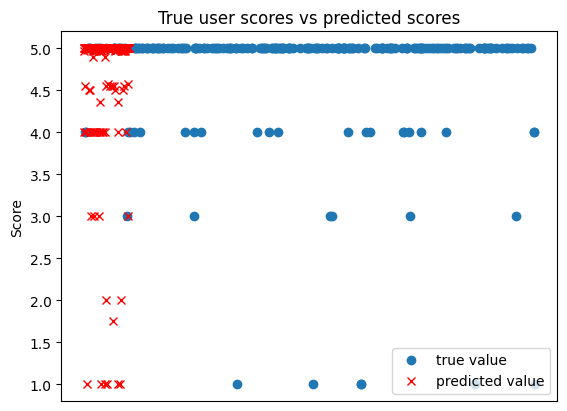

In [ ]:
plt.plot(true_scores, 'o', label = 'true value')
plt.plot(predictions, 'x', color = 'red', label = 'predicted value')
plt.title("True user scores vs predicted scores")
plt.ylabel("Score")
plt.legend()
plt.xticks([])
plt.show()

In [ ]:
model_df['score_class'] = model_df['review/score'].apply(lambda score: 0 if score >= 3.0 else 1)

=========== EVALUATION ===========
ACCURACY: 0.9732142857142857
PRECISION: 0.6666666666666666
RECALL: 0.5


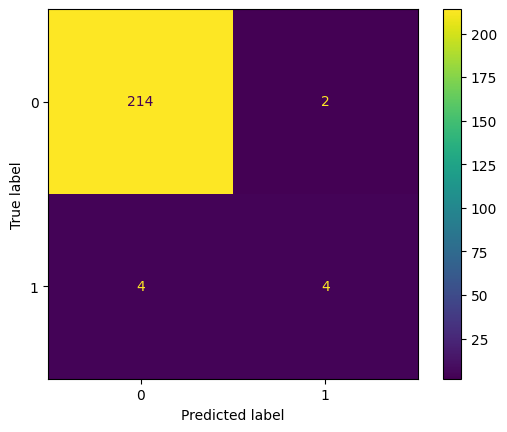

In [ ]:
predictions, true_scores = train_user_model(model_df.drop(columns = ['review/score', 'score_class']), model_df["score_class"], "classification", True)

<p> Bad precision and recall scores. I'm thinking a data issue</p>